# Chap 3 Classification
using the MNIST data set

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target
print(X)
print(type(X))
print(X.shape)
print(y)
print(y.shape) # 70000 images with 784 features each whew. 28 x 28 pixel grid

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


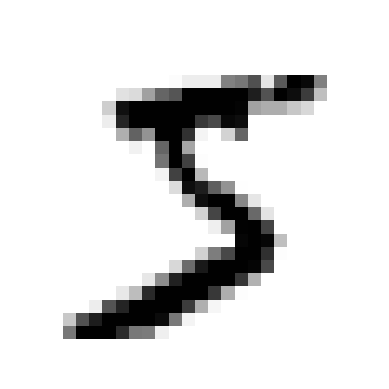

In [6]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
plt.show()

In [7]:
#what is our y
y[0]

'5'

The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):2 X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.⁠3

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 187). (Function). Kindle Edition.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == '5')
y_test_5 = (y_test== '5')



## Our First Classifier 5 or not 5

In [10]:
from sklearn.linear_model import SGDClassifier #stochasitc gradient descent
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


 - X_train: Contains all the training images (all digits 0-9)
  - y_train_5: Contains binary labels where True indicates the digit is a 5, and False indicates it's not a 5

  This is a classic example of a binary classification problem. The model learns to distinguish "5" from "not 5" (where "not 5" includes all other digits 0, 1, 2, 3, 4, 6, 7, 8, 9).

In [17]:
some_digit = X[0]
print(some_digit.shape)
sgd_classifier.predict(X[0].reshape(1, -1))

(784,)


array([ True])

## Performance Measures

### Cross Validation
We split the training set into K folds then train the model k times. saving a different fold each time for validation

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [19]:
#compare the resuls above with a dummy classifier that classifies every image as the most frequent -in this case Not Five.
from sklearn.dummy import  DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(dummy_clf.predict(X_train))

[False False False ... False False False]


In [20]:
#We should get 90% accuracy
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 191). (Function). Kindle Edition.

### Confusion Matrix

**cross_val_score**:
- Returns **evaluation scores** (one per fold)
- Use it to **evaluate** model performance
- Example: `[0.95, 0.96, 0.94]` (accuracy for each fold)

**cross_val_predict**:
- Returns **predictions** for each sample in the dataset
- Use it to **get predictions** that you can analyze (e.g., build confusion matrix, plot errors)
- Example: `[True, False, True, ...]` (predicted class for each training sample)

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

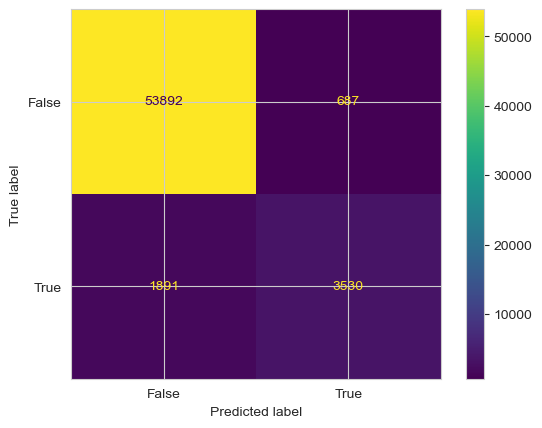

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train_5, y_train_pred)
# Each row is actual class and each column is predicted class
# The first row is non five or the the negative class. 687 numbers were incorrectly indentified as non fives. These are false negatives
# 1891 5s were wrongly classified as false. a false negative or type2 error
# a perfect classifier would  have only true positive and negative


### Precision and Recall

**Precision**: Of all the instances the model predicted as positive, how many were actually positive?

$$\text{Precision} = \frac{TP}{TP + FP}$$

Using our confusion matrix values:
- TP (True Positives) = 3,530 (correctly identified 5s)
- FP (False Positives) = 687 (wrongly classified as 5s)

$$\text{Precision} = \frac{3530}{3530 + 687} = \frac{3530}{4217} = 0.837 \text{ or } 83.7\%$$

This means when our classifier predicts a digit is a 5, it's correct about 84% of the time.

---

**Recall** (Sensitivity or True Positive Rate): Of all the actual positive instances, how many did the model correctly identify?

$$\text{Recall} = \frac{TP}{TP + FN}$$

Using our confusion matrix values:
- TP (True Positives) = 3,530 (correctly identified 5s)
- FN (False Negatives) = 1,891 (5s that were missed)

$$\text{Recall} = \frac{3530}{3530 + 1891} = \frac{3530}{5421} = 0.651 \text{ or } 65.1\%$$

This means our classifier correctly identifies about 65% of all actual 5s in the dataset.

In [28]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_train_5, y_train_pred))
print(precision_score(y_train_5, y_train_pred))

0.6511713705958311
0.8370879772350012


In [30]:
#We can combine precision and recall into the f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

#increasing precision will decrease recall and vice versa. f1 tends to favor models that are high in both.

0.7325171197343847

### The precision recall trade off
Increasing precision reduces recall and vice versa
Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 198). (Function). Kindle Edition.

In [32]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#we raised the theshold and drecresed recall. This was a 5 now we have a false negative or a type 2 error

array([False])

In [41]:
#Use cross val predict to get the scores of all values in the training set
from sklearn.metrics import  precision_recall_curve
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 1 and a last recall of 0, corresponding to an infinite threshold):

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 199). (Function). Kindle Edition.

In [43]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

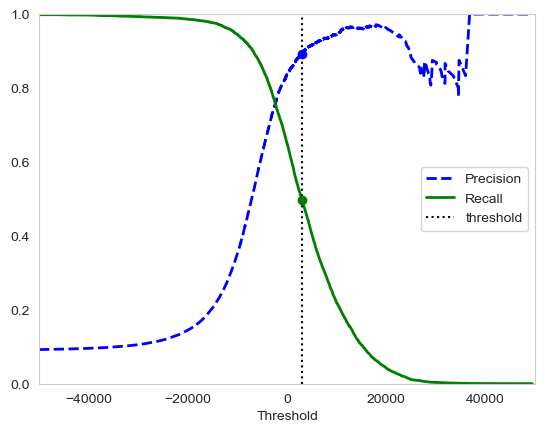

In [45]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")


plt.show()



Tip If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 203). (Function). Kindle Edition.

### The ROC Curve (Receiver Operating Characteristic)

The ROC curve is another way to evaluate a binary classifier by plotting **True Positive Rate** vs **False Positive Rate** at different thresholds.

#### Understanding the Terms (Using Our "5 vs Not-5" Example)

**Sensitivity (aka Recall or True Positive Rate - TPR)**
- Question: "Of all the actual 5s, how many did we catch?"
- Formula: $\text{TPR} = \frac{TP}{TP + FN} = \frac{3530}{3530 + 1891} = 0.651$
- **This is the SAME as Recall!**

**Specificity (True Negative Rate)**
- Question: "Of all the actual non-5s, how many did we correctly identify as non-5s?"
- Formula: $\text{Specificity} = \frac{TN}{TN + FP} = \frac{53892}{53892 + 687} = 0.987$
- This tells us how good we are at avoiding false alarms

**False Positive Rate (FPR)**
- This is simply: $\text{FPR} = 1 - \text{Specificity} = \frac{FP}{FP + TN}$
- Question: "Of all the actual non-5s, how many did we wrongly call 5s?"

---

#### Sensitivity/Specificity vs Precision/Recall - What's the Difference?

The key difference is **what denominator they use**:

| Metric | Formula | Question It Answers | Denominator Focus |
|--------|---------|---------------------|-------------------|
| **Recall (Sensitivity/TPR)** | $\frac{TP}{TP + FN}$ | Of all actual positives, how many did we find? | **Actual positives** |
| **Precision** | $\frac{TP}{TP + FP}$ | Of all our positive predictions, how many were right? | **Predicted positives** |
| **Specificity** | $\frac{TN}{TN + FP}$ | Of all actual negatives, how many did we correctly identify? | **Actual negatives** |

**The Key Insight:** When you increase the threshold, both Precision and Specificity improve (fewer false positives), while both Recall and Sensitivity decrease (more false negatives). They measure similar tradeoffs!

**The Subtle Difference:** 
- **Precision** focuses on the quality of your positive predictions (are my "5" predictions accurate?)
- **Specificity** focuses on correctly handling the negative class (am I good at identifying non-5s?)

**Use Precision/Recall when:**
- You have imbalanced data (like our 90% non-5s)
- You care more about the positive class performance
- False positives are costly (e.g., spam detection)

**Use Sensitivity/Specificity (ROC) when:**
- You care about both classes equally
- You want balanced data evaluation
- You want to see the tradeoff between catching positives and avoiding false alarms

---

#### What Makes a Good ROC Curve?

- **Perfect classifier**: Hugs the top-left corner (100% TPR, 0% FPR)
- **Random classifier**: Diagonal line from bottom-left to top-right (50/50 guess)
- **AUC (Area Under Curve)**: Higher is better (1.0 = perfect, 0.5 = random)

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [50]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991441817)

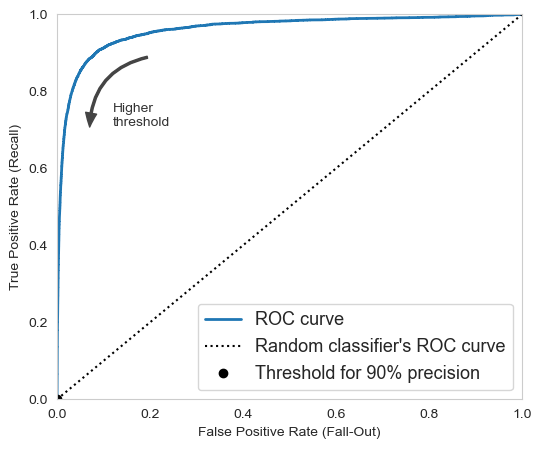

In [51]:
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)



In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 205). (Function). Kindle Edition.

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner (see Figure 3-6 again).

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 206). (Function). Kindle Edition.

## Use Random Forest Classifier to compare with SGD


In [56]:
from sklearn.ensemble import RandomForestClassifier
forrest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forrest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [57]:
y_probs_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [58]:
y_train_pred_forest = y_probs_forest[:, 1] >= .5 #postivie prob greater = 50
f1_score(y_train_5, y_train_pred_forest)


0.9270445185330457

In [60]:
y_scores_forest = y_probs_forest[:, 1]
y_scores_forest

array([0.89, 0.02, 0.04, ..., 0.98, 0.08, 0.07], shape=(60000,))

In [61]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

In [ ]:
##  Multiclass Classification


One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or sometimes one-versus-all (OvA).

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 210). (Function). Kindle Edition.

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 211). (Function). Kindle Edition.

In [62]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [63]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2) # 5 has the highest score

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])